# Image Recognition of Rock-Paper-Scissors Using Convolutional Neural Network (CNN)



*   Name: Novrizal Roynanda
*   Username: novrizalrnd
*   Email: novrizalroynanda@gmail.com



### Import Libraries

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import zipfile,os
import random
from google.colab import files
from IPython.display import Image as IMG
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix

# Import Deep Learning library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
local_zip = '/content/drive/MyDrive/Rock-Paper-Scissor/rockpaperscissors.zip'
zip_file = zipfile.ZipFile(local_zip, 'r')
zip_file.extractall('/tmp')
zip_file.close()

In [3]:
print('Number of Rock images: ', len(os.listdir('/tmp/rockpaperscissors/rock/')))
print('Number of Paper images: ', len(os.listdir('/tmp/rockpaperscissors/paper/')))
print('Number of Scissors images: ', len(os.listdir('/tmp/rockpaperscissors/scissors/')))

Number of Rock images:  726
Number of Paper images:  712
Number of Scissors images:  750


## Create Training and Testing Folder for Modeling

In [4]:
try:
  os.mkdir('/tmp/rockpaperscissors/training')
  os.mkdir('/tmp/rockpaperscissors/training/rock')
  os.mkdir('/tmp/rockpaperscissors/training/paper')
  os.mkdir('/tmp/rockpaperscissors/training/scissors')
  os.mkdir('/tmp/rockpaperscissors/testing')
  os.mkdir('/tmp/rockpaperscissors/testing/rock')
  os.mkdir('/tmp/rockpaperscissors/testing/paper')
  os.mkdir('/tmp/rockpaperscissors/testing/scissors')
except OSError:
  pass

## Split Data

In [5]:
def split_data(img_loc, train_data, test_data, split_size):
    files = []
    for filename in os.listdir(img_loc):
        file = img_loc + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    train_len = int(len(files) * split_size)
    test_len = int(len(files) - train_len)
    shuffled_set = random.sample(files, len(files))
    train_set = shuffled_set[0:train_len]
    test_set = shuffled_set[train_len:]

    for filename in train_set:
        this_file = img_loc + filename
        destination = train_data + filename
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = img_loc + filename
        destination = test_data + filename
        copyfile(this_file, destination)

rock_loc = "/tmp/rockpaperscissors/rock/"
rock_train_data = "/tmp/rockpaperscissors/training/rock/"
rock_test_data = "/tmp/rockpaperscissors/testing/rock/"

paper_loc = "/tmp/rockpaperscissors/paper/"
paper_train_data = "/tmp/rockpaperscissors/training/paper/"
paper_test_data = "/tmp/rockpaperscissors/testing/paper/"

scissors_loc = "/tmp/rockpaperscissors/scissors/"
scissors_train_data = "/tmp/rockpaperscissors/training/scissors/"
scissors_test_data = "/tmp/rockpaperscissors/testing/scissors/"

split_size = 0.6 # 60% Data Training and 20% Data Validation
split_data(rock_loc, rock_train_data, rock_test_data, split_size)
split_data(paper_loc, paper_train_data, paper_test_data, split_size)
split_data(scissors_loc, scissors_train_data, scissors_test_data, split_size)

train_data = len(os.listdir(rock_train_data)) + len(os.listdir(paper_train_data)) + len(os.listdir(scissors_train_data))
test_data = len(os.listdir(rock_test_data)) + len(os.listdir(paper_test_data)) + len(os.listdir(scissors_test_data))

print("Total training data has " + str(train_data) + " rows and validation data has " + str(test_data))

Total training data has 1312 rows and validation data has 876


## Image Augmentation

In [6]:
train_dir = '/tmp/rockpaperscissors/training/'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150,150)
)

validation_dir = "/tmp/rockpaperscissors/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


## Using Keras Callback Class

In [7]:
# Using a callback to early stopping the training epoch if reaches a certain threshold
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\nAccuracy above 97%, stop the training!")
      self.model.stop_training = True

callbacks = myCallback()

## Create a Plot Function

In [8]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

## Data Modeling with CNN

In [9]:
tf.keras.backend.clear_session()

model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## Running the Base Model

In [10]:
model_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    train_gen,
    epochs=100,
    callbacks = [callbacks],
    verbose=1,
    validation_data=validation_gen
)

Epoch 1/100
11/11 [==============================] - 86s 8s/step - loss: 1.0793 - accuracy: 0.4261 - val_loss: 0.9382 - val_accuracy: 0.7055
Epoch 2/100
11/11 [==============================] - 86s 8s/step - loss: 0.9255 - accuracy: 0.5777 - val_loss: 0.7114 - val_accuracy: 0.7078
Epoch 3/100
11/11 [==============================] - 87s 8s/step - loss: 0.6968 - accuracy: 0.7332 - val_loss: 0.2834 - val_accuracy: 0.9418
Epoch 4/100
11/11 [==============================] - 89s 8s/step - loss: 0.5730 - accuracy: 0.7569 - val_loss: 0.3608 - val_accuracy: 0.9110
Epoch 5/100
11/11 [==============================] - 78s 7s/step - loss: 0.4542 - accuracy: 0.8194 - val_loss: 0.1687 - val_accuracy: 0.9703
Epoch 6/100
11/11 [==============================] - 86s 8s/step - loss: 0.4237 - accuracy: 0.8384 - val_loss: 0.2220 - val_accuracy: 0.9498
Epoch 7/100
11/11 [==============================] - 84s 8s/step - loss: 0.4093 - accuracy: 0.8529 - val_loss: 0.1715 - val_accuracy: 0.9623
Epoch 8/100
1

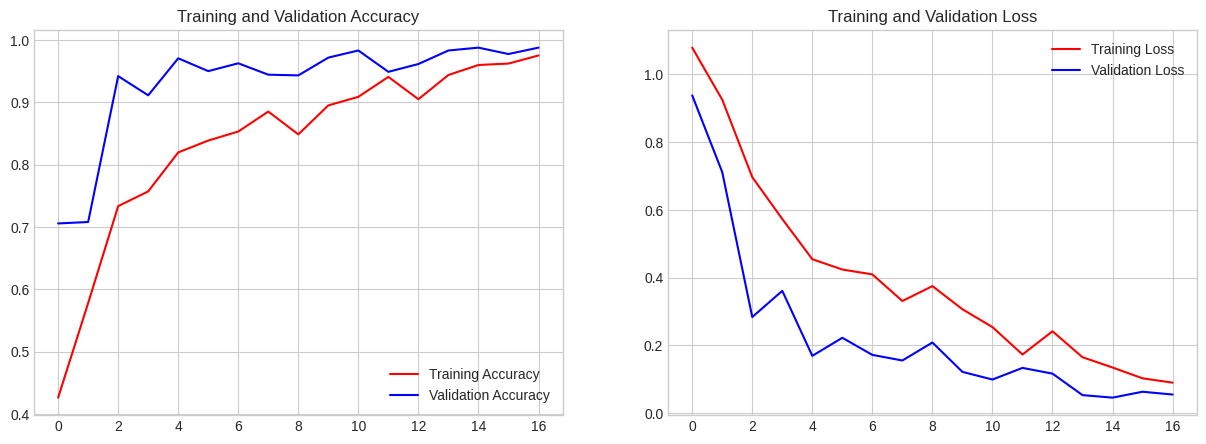

In [11]:
# visualization the base model
plot_history(history_simple)

## Evaluate the Base Model

In [12]:
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150, 150),
    shuffle = False
)

filenames = validation_gen.filenames
n_samples = len(filenames)

Y_pred = model_simple.predict_generator(validation_gen, steps = n_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_gen.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_gen.classes, y_pred, target_names=target_names))

Found 876 images belonging to 3 classes.


Confusion Matrix
[[279   1   5]
 [  2 287   2]
 [  1   0 299]]
Classification Report
              precision    recall  f1-score   support

        Rock       0.99      0.98      0.98       285
       Paper       1.00      0.99      0.99       291
    Scissors       0.98      1.00      0.99       300

    accuracy                           0.99       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.99      0.99      0.99       876



## Model Optimization Using Transfer Learning (InceptionV3)

In [13]:
tf.keras.backend.clear_session()

model_inception = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_inception.layers[0].trainable = False

model_inception.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 31242019 (119.18 MB)
Trainable params: 9439235 (36.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [14]:
model_inception.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_inception = model_inception.fit(
    train_gen,
    epochs=100,
    callbacks = [callbacks],
    verbose=1,
    validation_data=validation_gen
)

Epoch 1/100
11/11 [==============================] - 178s 15s/step - loss: 27.0856 - accuracy: 0.4360 - val_loss: 2.5571 - val_accuracy: 0.6587
Epoch 2/100
11/11 [==============================] - 157s 15s/step - loss: 2.8960 - accuracy: 0.7767 - val_loss: 0.6977 - val_accuracy: 0.9292
Epoch 3/100
11/11 [==============================] - 163s 15s/step - loss: 1.5723 - accuracy: 0.9101 - val_loss: 0.3116 - val_accuracy: 0.9578
Epoch 4/100
11/11 [==============================] - 157s 15s/step - loss: 0.8148 - accuracy: 0.9352 - val_loss: 0.2924 - val_accuracy: 0.9635
Epoch 5/100
11/11 [==============================] - 119s 11s/step - loss: 0.6092 - accuracy: 0.9383 - val_loss: 0.2160 - val_accuracy: 0.9715
Epoch 6/100
11/11 [==============================] - 157s 15s/step - loss: 0.2829 - accuracy: 0.9588 - val_loss: 0.1201 - val_accuracy: 0.9760
Epoch 7/100
11/11 [==============================] - 119s 11s/step - loss: 0.2251 - accuracy: 0.9611 - val_loss: 0.1060 - val_accuracy: 0.979

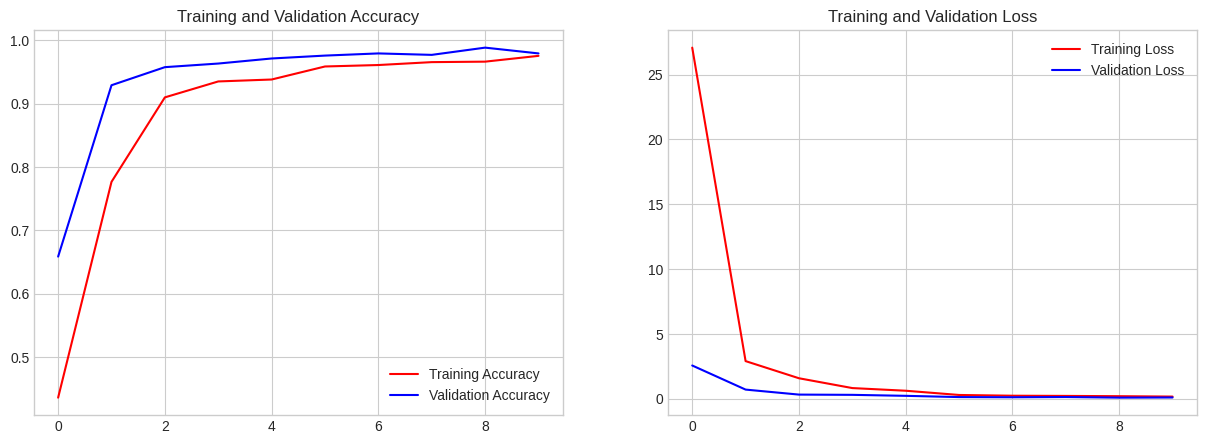

In [15]:
# visualization the transfer learning model
plot_history(history_inception)

## Model Evaluation

In [16]:
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150, 150),
    shuffle = False
)

filenames = validation_gen.filenames
n_samples = len(filenames)

Y_pred = model_inception.predict_generator(validation_gen, steps = n_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_gen.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_gen.classes, y_pred, target_names=target_names))

Found 876 images belonging to 3 classes.


Confusion Matrix
[[272   5   8]
 [  2 289   0]
 [  3   0 297]]
Classification Report
              precision    recall  f1-score   support

        Rock       0.98      0.95      0.97       285
       Paper       0.98      0.99      0.99       291
    Scissors       0.97      0.99      0.98       300

    accuracy                           0.98       876
   macro avg       0.98      0.98      0.98       876
weighted avg       0.98      0.98      0.98       876



## Create an Image Recognition Function

In [17]:
def img_recogn(img_upload, model = model_inception):
  img = img_upload
  img_array = np.asarray(img)
  img_array = img_array * (1/225)
  img_input = tf.reshape(img_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(img_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  df['Probability'] = round(df['Probability'] * 100 / sum(df['Probability']), 2)
  item = ['Paper', 'Rock', 'Scissors']
  df['Item'] = item
  df = df[['Item', 'Probability']]

  predict_label = np.argmax(model.predict(img_input))

  if predict_label == 0:
      predict_item = 'Paper'
  elif predict_label == 1:
      predict_item = 'Rock'
  else:
      predict_item = 'Scissors'

  return predict_item, df

## Result

Saving ADOiIs56eyYsunID.png to ADOiIs56eyYsunID.png
1/1 [==============================] - 0s 96ms/step




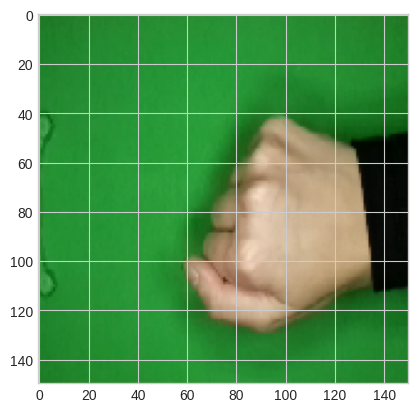


The image is detected as Rock


       Item  Probability
0     Paper     8.020000
1      Rock    90.980003
2  Scissors     1.000000




In [18]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = img_recogn(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')